# Randomized Search CV

**Benefits**: faster than Grid Search CV and more appropriate to use when there are many features to tune

In [105]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
import matplotlib.pyplot as plt
import time
import warnings
warnings.simplefilter("ignore", category=PendingDeprecationWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=FutureWarning)

In [106]:
SEED = 42

In [107]:
iris = load_iris()

In [108]:
X_train, X_test, y_train, y_test = train_test_split(iris["data"], 
                                                    iris["target"], 
                                                    test_size=0.2,
                                                    random_state=SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120, 4), (30, 4), (120,), (30,))

#### Train Base Model

In [34]:
rf = RandomForestClassifier(n_jobs=-1,
                            random_state=SEED)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [35]:
scores = cross_val_score(rf, X_train, y_train, cv=10, scoring="accuracy")
scores.mean(), scores.std()

(0.9248834498834497, 0.1146157810557605)

#### Scale Features

In [22]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [23]:
rf = RandomForestClassifier(n_jobs=-1,
                            random_state=SEED)
rf.fit(X_train, y_train)

scores = cross_val_score(rf, X_train, y_train, cv=10, scoring="accuracy")
scores.mean(), scores.std()

(0.9248834498834497, 0.1146157810557605)

#### Optimize Hyperparameters

In [110]:
def hyperparameter_tune(base_model, parameters, n_iter, kfold, X=X_train, y=y_train):
    start_time = time.time()
    
    # Arrange data into folds with approx equal proportion of classes within each fold
    k = StratifiedKFold(n_splits=kfold, shuffle=False)
    
    optimal_model = RandomizedSearchCV(base_model,
                            param_distributions=parameters,
                            n_iter=n_iter,
                            cv=k,
                            n_jobs=-1,
                            random_state=SEED)
    
    optimal_model.fit(X, y)
    
    stop_time = time.time()

    scores = cross_val_score(optimal_model, X, y, cv=k, scoring="accuracy")
    
    print("Elapsed Time:", time.strftime("%H:%M:%S", time.gmtime(stop_time - start_time)))
    print("====================")
    print("Cross Val Mean: {:.3f}, Cross Val Stdev: {:.3f}".format(scores.mean(), scores.std()))
    print("Best Score: {:.3f}".format(optimal_model.best_score_))
    print("Best Parameters: {}".format(optimal_model.best_params_))
    
    return optimal_model.best_params_, optimal_model.best_score_

In [111]:
base_model = RandomForestClassifier(n_jobs=-1,
                                   random_state=SEED)

parameters = {
    "max_depth": [3, 5, 10, None],
    "n_estimators": [100, 200, 300, 400, 500],
    "max_features": randint(1, 3),
    "criterion": ["gini", "entropy"],
    "bootstrap": [True, False],
    "min_samples_leaf": randint(1, 4)
}

best_params, best_score = hyperparameter_tune(base_model, parameters, 10, 5, X_train, y_train)

Elapsed Time: 00:00:04
Cross Val Mean: 0.942, Cross Val Stdev: 0.077
Best Score: 0.950
Best Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 3, 'n_estimators': 300}


#### Visualize the Impact of Varying the Number of Folds

In [112]:
scores = []
folds = range(2, 10)

for i in folds:
    print("\ncv = ", i)
    best_params, best_score = hyperparameter_tune(base_model, parameters, 10, i, X_train, y_train)
    scores.append(best_score)


cv =  2
Elapsed Time: 00:00:01
Cross Val Mean: 0.925, Cross Val Stdev: 0.007
Best Score: 0.933
Best Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 2, 'n_estimators': 200}

cv =  3
Elapsed Time: 00:00:01
Cross Val Mean: 0.942, Cross Val Stdev: 0.047
Best Score: 0.950
Best Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 3, 'n_estimators': 300}

cv =  4
Elapsed Time: 00:00:02
Cross Val Mean: 0.933, Cross Val Stdev: 0.041
Best Score: 0.942
Best Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 3, 'n_estimators': 500}

cv =  5
Elapsed Time: 00:00:02
Cross Val Mean: 0.942, Cross Val Stdev: 0.077
Best Score: 0.950
Best Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 3, 'n_estimators': 300}

cv =  6
Elapsed Time: 00:00:03
Cross Val Me

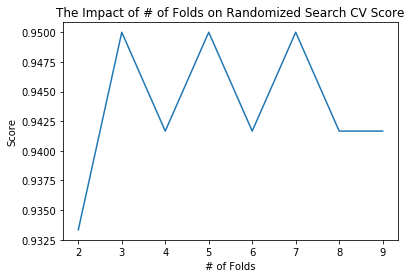

In [113]:
plt.plot([x for x in folds], scores)
plt.xlabel("# of Folds")
plt.ylabel("Score")
plt.title("The Impact of # of Folds on Randomized Search CV Score")
plt.show()

#### Train a Model Using Optimal Number of Folds

In [114]:
best_cv = [x for x in folds][np.argmax(scores)]

best_params, best_score = hyperparameter_tune(base_model, parameters, 10, best_cv, X_train, y_train)

Elapsed Time: 00:00:01
Cross Val Mean: 0.942, Cross Val Stdev: 0.047
Best Score: 0.950
Best Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 3, 'n_estimators': 300}
